### File Explanation 

**eQTL_LD_HBTRC.ipynb:**
<br> This notebook is to interpret cis- eQTL analysis and LD results generated in 'linkage_Disequilibrium_HBTRC_vX.RData', where X denotes the power of p-value as {2, 3, 4, 5} --> {1e-2, 1e-3, 1e-4, 1e-5}

**Necessary documents**: 
<br>linkageDisequilibrium_ANM_vX.Rdata files and preprocessData.pickle are compulsory in order to carry out within-pair LD analysis and find F1 scores.

**The processes are as follows:**
<br> 1) Load information from HBTRC study data ('preprocessData_HBTRC.pickle') to retrieve test_Pairs
<br> 2) Load information from eQTL analysis and LD tables, produced by 'linkage_Disequilibrium_HBTRC_vX.RData', in Pandas format 
<br> 3) Fetch TFs and targets as well as gene-interaction pairs from cis- analysis based on the criteria FDR < 10e-1
<br> 4) Eliminate pairs by within-pair LD and add pairs by between-pair LD (function: **dropWithinPairsLD** in **eqtl_utils.py**)
<br> 5) Get eQTL predicted labels (eqtl_labels) for test_Pairs 
<br> 6) Calculate F1 score and plot F1 score with respect to different p-values
<br> 7) Plot **'linkage disequilibrium between interacting variants'**

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import os

# Set up environment variables for rpy2 to work
os.environ['R_HOME'] = '/usr/local/Cellar/r/3.6.0_2/lib/R'
os.environ['R_USER'] = '/usr/local/lib/python3.7/site-packages/rpy2'

In [2]:
# LOAD HBTRC DATA
# Load data form the pickle produced by "preprocessData_v1.ipsynb"

# Save data into Python friendly file
import pickle
with open('../../../HBTRC/preprocessData_HBTRC.pickle', 'rb') as f:
    rSnpA_nXSN = pickle.load( f )
    rSnpB_nXSN = pickle.load( f )
    rRnaA_nXS = pickle.load( f )
    rRnaB_nXS = pickle.load( f )
    rRelated_nXC = pickle.load( f )
    rSnpA_tr_nXSN = pickle.load( f )
    rSnpB_tr_nXSN = pickle.load( f )
    rRnaA_tr_nXS = pickle.load( f )
    rRnaB_tr_nXS = pickle.load( f )
    rRelated_tr_nXC = pickle.load( f )
    rSnpA_tst_nXSN = pickle.load( f )
    rSnpB_tst_nXSN = pickle.load( f )
    rRnaA_tst_nXS = pickle.load( f )
    rRnaB_tst_nXS = pickle.load( f )
    rRelated_tst_nXC = pickle.load( f )
    sGeneNames_nX2 = pickle.load( f )
    sGeneNames_tr_nX2 = pickle.load( f )
    sGeneNames_tst_nX2 = pickle.load( f )
    nRs = pickle.load( f )
    nSs = pickle.load( f )
    print( 'Data saved into pickle.' )

iSnum = rSnpA_nXSN.shape[ 1 ] # Number of subjects
iNnum = rSnpA_nXSN.shape[ 2 ] # Number of snps
iCnum = rRelated_nXC.shape[ 1 ] # Number of classes

print('All samples loaded' )
print('Number of training samples (transcripts) of gene A: {}'.format( rSnpA_tr_nXSN.shape[ 0 ] ) )
print('Number of training samples (transcripts) of gene B: {}'.format( rSnpB_tr_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene A: {}'.format( rSnpA_tst_nXSN.shape[ 0 ] ) )
print('Number of test samples (transcripts) of gene B: {}'.format( rSnpB_tst_nXSN.shape[ 0 ] ) )
print('Number of subjects iSnum: {}'.format( rSnpA_nXSN.shape[ 1 ] ) )
print('Number of SNPs iNnum: {}'.format( rSnpA_nXSN.shape[ 2 ] ) )
print('Number of association classes iCnum: {}'.format( rRelated_nXC.shape[ 1 ] ) )

Data saved into pickle.
All samples loaded
Number of training samples (transcripts) of gene A: 1500
Number of training samples (transcripts) of gene B: 1500
Number of test samples (transcripts) of gene A: 45
Number of test samples (transcripts) of gene B: 45
Number of subjects iSnum: 434
Number of SNPs iNnum: 100
Number of association classes iCnum: 3


### eQTL and within-Pair LD analysis

In [33]:
%run eqtl_utils.py

# Load Rdata with rpy2
import rpy2
import pandas as pd
import numpy as np
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
# Clear the workspace
r( 'rm( list = ls( ) )' )

# 16GB memory limit
r( 'memory.limit( 16000 )' )
linkageDiseqilibriumData = ['linkage_Disequilibrium_HBTRC_2.RData', 'linkage_Disequilibrium_HBTRC_3.RData',
                            'linkage_Disequilibrium_HBTRC_4.RData', 'linkage_Disequilibrium_HBTRC_5.RData']

pvalues = [1e-2, 1e-3, 1e-4, 1e-5]
F1_score = [None] * len(pvalues)
nPairs = [None] * len(pvalues)

for iData in range(len(linkageDiseqilibriumData)):
    r['load'](linkageDiseqilibriumData[iData])
    print( 'Data loaded from {} file.'.format(linkageDiseqilibriumData[iData]) )
    
    import pandas as pd
    linkageDisequilibrium_nN = r('LD_cis_HBTRC$R^2')
    cisSnps = np.array( r( 'cis_snps') )
    ldSnps = np.array( r( 'ld_snps' ) )

    # Within-pair LD
    cisWithinSnps_0 = ldSnps[np.where(linkageDisequilibrium_nN > 0.6)[0]]
    cisWithinSnps_1 = ldSnps[np.where(linkageDisequilibrium_nN > 0.6)[1]]
    cisWithinSnps_0_1 = np.unique(np.hstack((cisWithinSnps_0, cisWithinSnps_1)))

    # Within-pair LD
    cisWithinLDSNP_dCN = dict(zip([cisWithinSnps_0_1[i] for i in range( len( cisWithinSnps_0_1 ) )], 
                            [cisWithinSnps_1[np.where(cisWithinSnps_0_1[i] == cisWithinSnps_0)[0]].tolist() + 
                             cisWithinSnps_0[np.where(cisWithinSnps_0_1[i] == cisWithinSnps_1)[0]].tolist()
                             for i in range(len(cisWithinSnps_0_1))] ))
    
    # cis-eQTL
    cisEQTL_pN7 = r['cis_eqtls_all']

    cisGenes_nCG = np.unique(cisEQTL_pN7['gene'])
    geneSnps_lCG = [cisEQTL_pN7['snps'][np.where(iG == cisEQTL_pN7['gene'])[0]].tolist() for iG in cisGenes_nCG]
    newd = [dropWithinPairsLD(cisEQTL_pN7, cisGenes_nCG[i], geneSnps_lCG[i], cisWithinLDSNP_dCN) 
            for i in range(len(cisGenes_nCG))]

    # Turn the dtypes of 'snps', 'genes_of_snps', and 'gene' column into string (object in pandas)
    cisEQTL_pN7[['snps', 'genes_of_snps', 'gene']] = cisEQTL_pN7[['snps', 'genes_of_snps', 'gene']].astype('str')

    # Get transcription factors and targets based on the criteria of FDR < 10%, FDR: false discovery rate

    nCisTFs = cisEQTL_pN7[cisEQTL_pN7['FDR'] < 0.1]['genes_of_snps'].to_numpy()
    nCisTargets = cisEQTL_pN7[cisEQTL_pN7['FDR'] < 0.1]['gene'].to_numpy()
    
    nPairs[iData] = len(nCisTFs)
    print("Number of gene pairs from eQTL analysis: ", len(nCisTFs))

    # Retrieve true labels of test examples
    test_Pairs = sGeneNames_tst_nX2
    num_examples_class = int(len(test_Pairs)/3)
    true_test_labels = [1] * num_examples_class + [2] * num_examples_class + [3] * num_examples_class

    # Predicted eQTL labels
    eqtl_labels = [None] * len(test_Pairs)

    for idx in range(len(test_Pairs)):
        geneA = test_Pairs[idx][0]
        geneB = test_Pairs[idx][1]

        index_A = np.where(geneA == nCisTFs)[0]
        index_B = np.where(geneB == nCisTFs)[0]

        # +1 output (--> interaction) check
        if len(index_A) != 0: 
            for i in index_A:
                eqtl_labels[idx] = 1 if(geneB == nCisTargets[i]) else 3   

        # +2 output (<-- interaction) check, instead of -1 for the correct calculation of f1_score 
        if len(index_B) != 0: 
            for i in index_B:
                eqtl_labels[idx] = 2 if(geneA == nCisTargets[i]) else 3

        # +3 output (no interaction) check, instead of 0 for the correct calculation of f1_score 
        elif len(index_A) == 0 or len(index_B) == 0:
            eqtl_labels[idx] = 3 

    # F1 score of test example
    from sklearn.metrics import f1_score
    f1_score = f1_score(true_test_labels, eqtl_labels, average='micro')

    print("F1 score: {}".format(f1_score))  
    F1_score[iData] = f1_score
    

Data loaded from linkage_Disequilibrium_HBTRC_2.RData file.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


Number of gene pairs from eQTL analysis:  421
F1 score: 0.3333333333333333
Data loaded from linkage_Disequilibrium_HBTRC_3.RData file.
Number of gene pairs from eQTL analysis:  432
F1 score: 0.3333333333333333
Data loaded from linkage_Disequilibrium_HBTRC_4.RData file.
Number of gene pairs from eQTL analysis:  334
F1 score: 0.3333333333333333
Data loaded from linkage_Disequilibrium_HBTRC_5.RData file.
Number of gene pairs from eQTL analysis:  217
F1 score: 0.3333333333333333


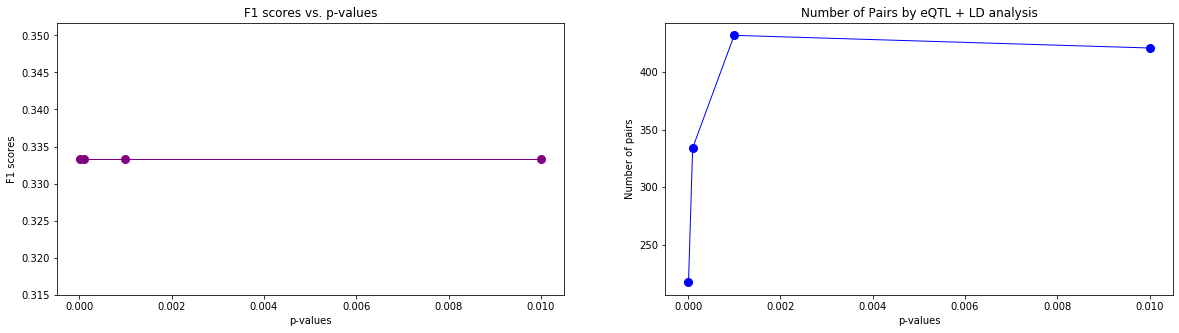

In [40]:
import matplotlib.pyplot as plt 

width = 20
height = 5
plt.figure( figsize = ( width, height ) )

plt.subplot(1,2,1)
plt.plot(pvalues, F1_score, marker='o', markerfacecolor='purple', markersize=8, color='purple', linewidth=1)
plt.xlabel("p-values")
plt.ylabel("F1 scores")
plt.title("F1 scores vs. p-values")

plt.subplot(1,2,2)
plt.plot(pvalues, nPairs, marker='o', markerfacecolor='blue', markersize=8, color='blue', linewidth=1)
plt.xlabel("p-values")
plt.ylabel("Number of pairs")
plt.title("Number of Pairs by eQTL + LD analysis")
plt.show()

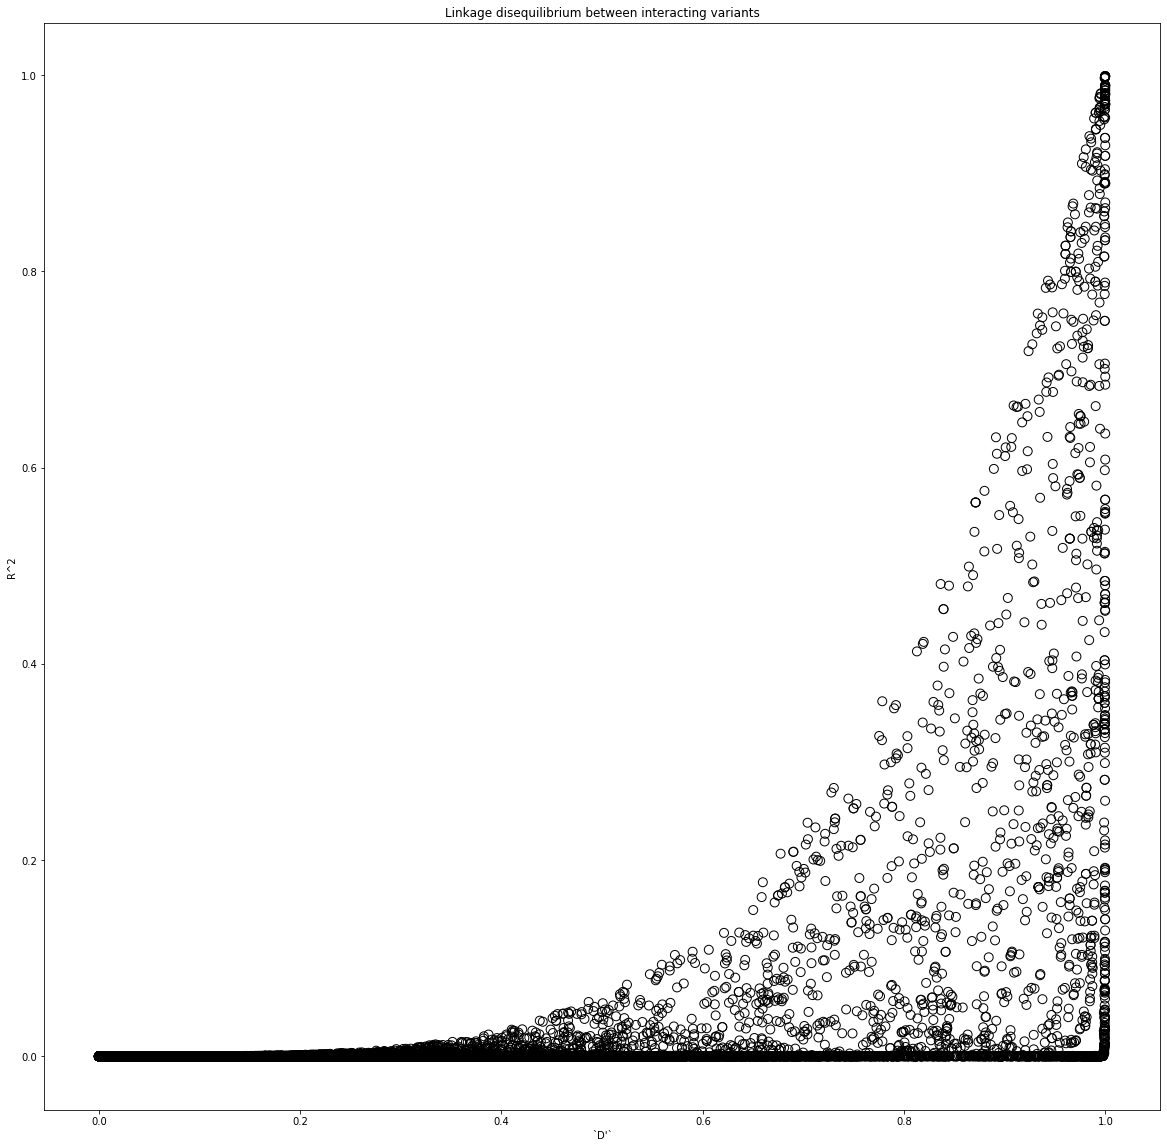

In [39]:
r2 = r('LD_cis_HBTRC$R^2')
d2 = r("LD_cis_HBTRC$`D'`")

width = 20
height = 20
plt.figure( figsize = ( width, height ) )

plt.scatter(d2, r2, s=80, facecolors='none', edgecolors='k')
plt.xlabel("`D'`")
plt.ylabel('R^2')
plt.title("Linkage disequilibrium between interacting variants")
plt.show()

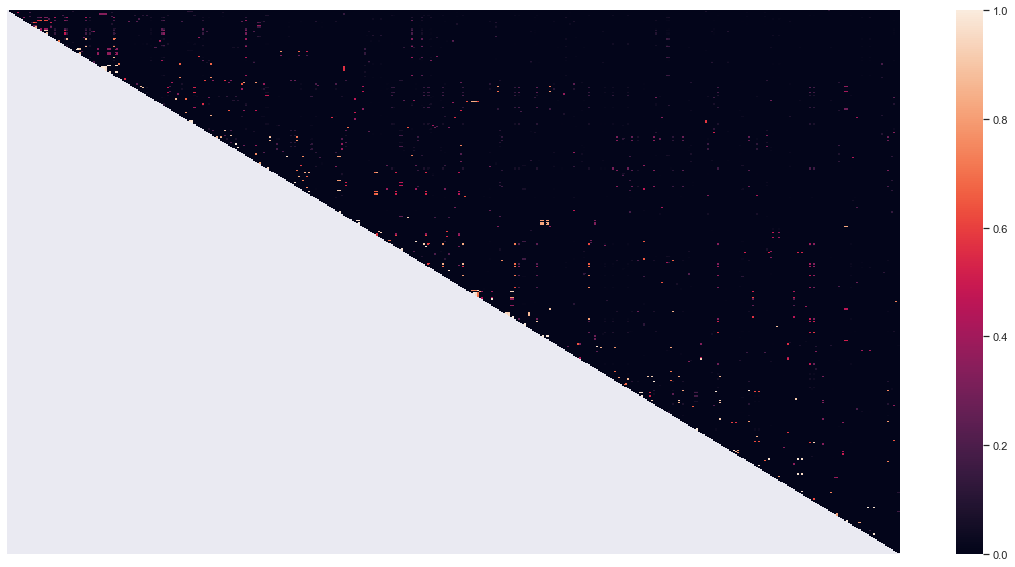

In [41]:
# Heatmap of linkage disequilibrium between interacting variants
import seaborn as sns
sns.set(rc={'figure.figsize':(20,10)})
mask = np.zeros_like(r2)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(r2, vmax=1, xticklabels=False, yticklabels=False)